In [17]:
import torch
import scipy
from scipy import ndimage, special
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import pandas as pd
from pyparsing import *
import numpy as np
import sklearn.preprocessing
from sklearn import datasets, linear_model

import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [2]:
l = 1
lambd = 1e-6

In [32]:
def calc_results(network, x_test, y_test, inv_preproc, N, p_dropout, T=100):
    
    tau = p_dropout * l ** 2 / (2 * N * lambd)
    
    X_test = Variable(torch.FloatTensor(x_test)).unsqueeze(1)

    _, prediction = inv_preproc(x_test, network(X_test).data.numpy()[:,0])
    _, recovered_y_test = inv_preproc(x_test, y_test)
    plt.plot(x_test, prediction)
    plt.plot(x_test, recovered_y_test)

    network.train()

    data_RMSE = []
    data_LL = []
    for i in range(T):
        _, prediction = inv_preproc(x_test, network(X_test).data.numpy()[:,0])
        MSE = mean_squared_error(prediction, recovered_y_test)
        LL = special.logsumexp(-0.5 * tau * (prediction - recovered_y_test) ** 2) - np.log(T) - 0.5 * np.log(2 * np.pi) + 0.5 * np.log(tau)
        data_LL.append(LL)
        data_RMSE.append(np.sqrt(MSE))

    data_RMSE, data_LL = np.array(data_RMSE), np.array(data_LL)
    print('Results:')
    print('RMSE:', data_RMSE.mean().round(2), '+-', data_RMSE.std().round(3), '\n',
          'LL: ', data_LL.mean().round(2), '+-', data_LL.std().round(3))
    

# Solar Irrad

In [52]:
def load_data():
    N=391
    df=pd.read_csv('Sol_Irrad.txt', sep=',')

    data = np.zeros(shape=(N, 2))
    mod_name = Word(nums)
    mod_dots = Word(nums + '.')
    parse_module = mod_dots + mod_dots + mod_dots

    for i in range(df.shape[0]):
        b = parse_module.parseString(df.values[i][0])
        data[i, 0] = np.float(b[2])
        data[i, 1] = np.float(b[0])
    
    return data

def preproc(data):
    def inv_preproc(x, y):
        data = np.array([y, x]).T
        data = scaler.inverse_transform(data)
        x = data[:, 1]
        y = data[:, 0]
        return x, y
    
    data = data.copy()
    
    train_data = np.asarray(data[:15, :].tolist() + data[35:95, :].tolist() + data[115:175, :].tolist() \
                          + data[195:255, :].tolist() + data[275:335, :].tolist() + data[355:, :].tolist())
    test_data  = np.asarray(data[15:35, :].tolist() + data[95:115, :].tolist() + data[175:195, :].tolist() \
                          + data[255:275, :].tolist() + data[335:355, :].tolist())
    
    
    scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(train_data)
    
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    x_train = train_data[:, 1]
    y_train = train_data[:, 0]
    x_test = test_data[:, 1]
    y_test = test_data[:, 0]
    
    return (x_train, y_train, x_test, y_test), inv_preproc

Results:
RMSE: 0.26 +- 0.005 
 LL:  0.31 +- 0.087


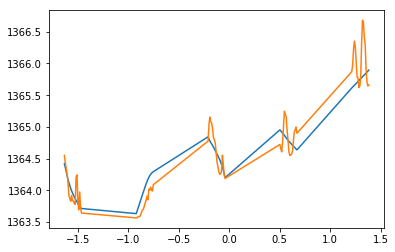

In [53]:
data = load_data()
(x_train, y_train, x_test, y_test), inv_preproc = preproc(data)

network = torch.load('solarirrad_linear_relu_network.p', map_location='cpu')

calc_results(network, x_test, y_test, inv_preproc, N=291, p_dropout=0.2)

Results:
RMSE: 0.33 +- 0.0 
 LL:  0.58 +- 0.0


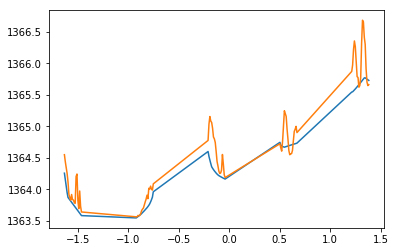

In [54]:
data = load_data()
(x_train, y_train, x_test, y_test), inv_preproc = preproc(data)

network = torch.load('solarirrad_linear_relu_network-2 (1).p', map_location='cpu')

calc_results(network, x_test, y_test, inv_preproc, N=291, p_dropout=0.2)

# CO2

In [40]:
def load_data():
    
    N = 721
    df=pd.read_csv('Mauna_Loa_CO2.csv', sep=',')
    
    data = np.zeros(shape=(N, 2))
    mod_name = Word(nums)
    mod_dots = Word(nums + '.' + '-')
    parse_module = mod_name + mod_name + mod_dots + mod_dots + mod_dots

    for i in range(df.shape[0]):
        b = parse_module.parseString(df.values[i][0])
        data[i, 0] = np.float(b[4])
        data[i, 1] = np.float(b[2])
    
    return data

def preproc(data):
    def inv_preproc(x, y):
        data = np.array([y,x]).T
        data = scaler.inverse_transform(data)
        x = data[:,1]
        y = data[:,0]
        y_trend = regr.predict(x[:,np.newaxis])
        y  = y + y_trend
        return x, y
    
    data = data.copy()
    train = data[:500, :]
    test = data[500:, :]
    
    x_train = train[:, 1]
    y_train = train[:, 0]
    x_test = test[:, 1]
    y_test = test[:, 0]
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train[:,np.newaxis], y_train)
    
    y_train_trend = regr.predict(x_train[:,np.newaxis])
    y_train  = y_train - y_train_trend
    
    y_test_trend = regr.predict(x_test[:,np.newaxis])
    y_test  = y_test - y_test_trend

    
    train[:,0] = y_train
    test[:,0] = y_test
    
    scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(train)

    train = scaler.transform(train)
    test = scaler.transform(test)
    
    x_train = train[:, 1]
    y_train = train[:, 0]
    x_test = test[:, 1]
    y_test = test[:, 0]
    
    return (x_train, y_train, x_test, y_test),inv_preproc

In [41]:
data = load_data()

(x_train, y_train, x_test, y_test), inv_preproc = preproc(data)

Results:
RMSE: 3.91 +- 0.081 
 LL:  -1.61 +- 0.462


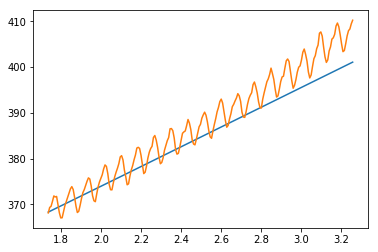

In [43]:
# 1
network = torch.load('linear_network.p', map_location='cpu')

calc_results(network, x_test, y_test, inv_preproc, N=500, p_dropout=0.2)

Results:
RMSE: 3.25 +- 0.083 
 LL:  -1.4 +- 0.382


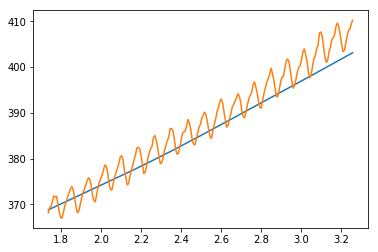

In [44]:
# 2
network = torch.load('linear_relu_network.p', map_location='cpu')

calc_results(network, x_test, y_test, inv_preproc, N=500, p_dropout=0.2)

Results:
RMSE: 7.94 +- 0.024 
 LL:  -3.13 +- 2.098


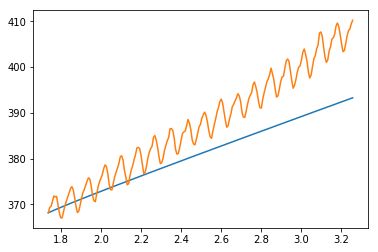

In [45]:
# 3
network = torch.load('linear_tanh_network.p', map_location='cpu')

calc_results(network, x_test, y_test, inv_preproc, N=500, p_dropout=0.2)

# Results 

| |Dropout| | No Dropout |
|:-|---|---|
| **Name** | **RMSE** | **LL** | **RMSE** | **LL** |
| CO2: Linear network | 3.92 $\pm$ 0.08 |-1.61 $\pm$ 0.46 | 
| CO2: Linear relu network| 3.24 $\pm$ 0.08| -1.4 $\pm$ 0.38|
| CO2: Linear tanh network| 7.94 $\pm$ 0.02 | -3.13 $\pm$ 2.1| 
| Solar irrad: Linear relu network| 0.26 $\pm$ 0.005| 0.31  $\pm$  0.09 | 0.33 | 0.58 |